In [1]:
import numpy as np

In [2]:
from jobflow import job, Flow

In [3]:
from pyiron_base import Project

In [4]:
from python_workflow_definition.jobflow import write_workflow_json

In [5]:
from python_workflow_definition.pyiron_base import load_workflow_json

In [6]:
from quantum_espresso_workflow import (
    calculate_qe as _calculate_qe, 
    generate_structures as _generate_structures, 
    get_bulk_structure as _get_bulk_structure, 
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [7]:
calculate_qe = job(_calculate_qe, data=["energy", "volume", "structure"])
generate_structures = job(_generate_structures, data=[f"s_{i}" for i in range(100)])
plot_energy_volume_curve = job(_plot_energy_volume_curve)
get_bulk_structure = job(_get_bulk_structure)

In [8]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [9]:
structure = get_bulk_structure(
    element="Al",
    a=4.05,
    cubic=True,
)

In [10]:
calc_mini = calculate_qe(
    working_directory="mini",
    input_dict={
        "structure": structure.output,
        "pseudopotentials": pseudopotentials,
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
    },
)

In [11]:
number_of_strains = 5
structure_lst = generate_structures(
    structure=calc_mini.output.structure,
    strain_lst=np.linspace(0.9, 1.1, number_of_strains),
)

In [12]:
job_strain_lst = []
for i in range(number_of_strains):
    calc_strain = calculate_qe(
        working_directory="strain_" + str(i),
        input_dict={
            "structure": getattr(structure_lst.output, str(i)),
            "pseudopotentials": pseudopotentials,
            "kpts": (3, 3, 3),
            "calculation": "scf",
            "smearing": 0.02,
        },
    )
    job_strain_lst.append(calc_strain)

In [13]:
plot = plot_energy_volume_curve(
    volume_lst=[job.output.volume for job in job_strain_lst],
    energy_lst=[job.output.energy for job in job_strain_lst],
)

In [14]:
flow = Flow([structure, calc_mini, structure_lst] + job_strain_lst + [plot])

In [15]:
write_workflow_json(flow=flow, file_name="workflow_jobflow.json")

In [16]:
!cat workflow_jobflow.json

{"nodes": {"0": "quantum_espresso_workflow.get_bulk_structure", "1": "quantum_espresso_workflow.calculate_qe", "2": "quantum_espresso_workflow.generate_structures", "3": "quantum_espresso_workflow.calculate_qe", "4": "quantum_espresso_workflow.calculate_qe", "5": "quantum_espresso_workflow.calculate_qe", "6": "quantum_espresso_workflow.calculate_qe", "7": "quantum_espresso_workflow.calculate_qe", "8": "quantum_espresso_workflow.plot_energy_volume_curve", "9": "Al", "10": 4.05, "11": true, "12": "mini", "13": "python_workflow_definition.jobflow.get_dict", "14": {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}, "15": [3, 3, 3], "16": "vc-relax", "17": 0.02, "18": [0.9, 0.9500000000000001, 1.0, 1.05, 1.1], "19": "strain_0", "20": "python_workflow_definition.jobflow.get_dict", "21": "scf", "22": "strain_1", "23": "python_workflow_definition.jobflow.get_dict", "24": "strain_2", "25": "python_workflow_definition.jobflow.get_dict", "26": "strain_3", "27": "python_workflow_definition.jobflow.get_dict", 

In [17]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

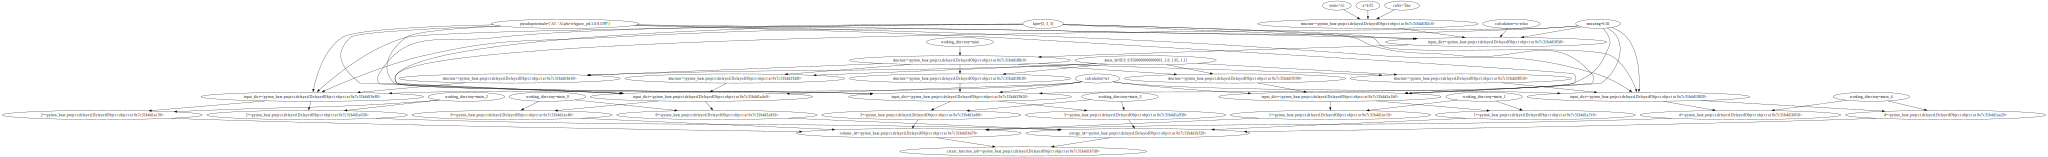

In [18]:
delayed_object = load_workflow_json(project=pr, file_name="workflow_jobflow.json")
delayed_object.draw()

The job get_bulk_structure_40d4be995c851afca48e5650f5e2d787 was saved and received the ID: 1
The job get_dict_bccb1cf45d545b4187a57ac7e53a7f00 was saved and received the ID: 2
The job calculate_qe_1b41e67724a7f43d770185783035d160 was saved and received the ID: 3


[jupyter-jan-janssen-pyt-flow-definition-0gcm79y7:00271] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_9587ea80d4ae39fde016d9679db04033 was saved and received the ID: 4
The job get_dict_9341dc849896355205022dc393c01d46 was saved and received the ID: 5
The job calculate_qe_865c57c1d9f63b47d007ff4e29a79bcf was saved and received the ID: 6


[jupyter-jan-janssen-pyt-flow-definition-0gcm79y7:00286] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_caeeba9c2e636a0a2e4f521c5c45a5ec was saved and received the ID: 7
The job calculate_qe_bac6ab05ad881ee3dd6f7b7bcc9733c0 was saved and received the ID: 8


[jupyter-jan-janssen-pyt-flow-definition-0gcm79y7:00297] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_3c1dc10e66c8ae32a3b4b27f0cba6c3f was saved and received the ID: 9
The job calculate_qe_71d64b1736003745767a4e3919a051b4 was saved and received the ID: 10


[jupyter-jan-janssen-pyt-flow-definition-0gcm79y7:00308] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_867e1f207d6fa437181062461e609943 was saved and received the ID: 11
The job calculate_qe_8712848b85e12a80ebdd9a666e63622d was saved and received the ID: 12


[jupyter-jan-janssen-pyt-flow-definition-0gcm79y7:00319] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_6fa378cba5c6963b82440d4afdca7e2e was saved and received the ID: 13
The job calculate_qe_fb13b133dee87016b8479c393a8c7d87 was saved and received the ID: 14


[jupyter-jan-janssen-pyt-flow-definition-0gcm79y7:00335] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_56ca34376ea987f3f7e914d63d5c4354 was saved and received the ID: 15
The job get_list_d4c43df1226fc8ef49ffcfef683c4c13 was saved and received the ID: 16
The job plot_energy_volume_curve_d29710bff91802a34165a810862c773e was saved and received the ID: 17


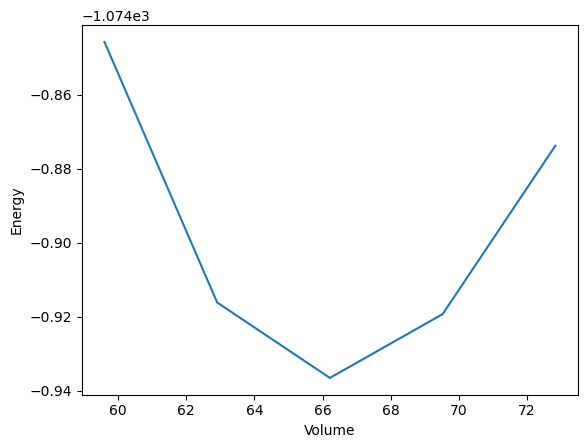

In [19]:
delayed_object.pull()